# Classification Modeling

- The question being asked in this project is if we can predict whether or not someone experiences food insecurity or not. Since this is a question with either a this or that answer, classification modeling will be used to get the predictions.
- The models that will be explored include Random Forest Classifier, Logistic Regression, Decision Trees, Bagging Decision Trees, and Support Vector Classifier.
- The goal will be to get a model that is not over or underfit as well as a modle that minimizes the false negatives. It is important to minimize false negatives because that would mean we are predicting people to be food secure when in actuality they are experiencing food insecurity. Wrongfully classifying those individuals would result in them not recieving the means necessary or having access to affordable foods and the goal of this project is to build a model that will allow for policy makers to allocate enough resources to households who experience food insecurity.

### Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV 

from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, confusion_matrix, \
classification_report, recall_score, precision_score, plot_confusion_matrix

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

from sklearn.preprocessing import StandardScaler, PolynomialFeatures 

from category_encoders import TargetEncoder

from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('./data/cleaned_data.csv')

In [3]:
df.shape

(48870, 33)

In [4]:
df.head()

,HEFAMINC,HRNUMHOU,PRTAGE,PERET1,PEHRUSLT,PRNMCHLD,QSTNUM,HESP6,HESP7,HESP7A,...,race,marital_status,food_pantry,has_dis,service_status,job_loss,type_job,in_union,in_school,has_stamps
0,100000,4,30,0,60,2,1,0,0,0,...,White,yes,Unknown,No,No,No,ForProf,No,No,no
1,75000,3,20,0,40,1,2,0,0,0,...,White,yes,Unknown,No,No,No,ForProf,No,College,no
2,25000,3,20,0,0,1,5,0,0,2,...,White,yes,Yes,No,No,No,0,No,No,no
3,50000,1,20,0,40,0,6,0,0,0,...,Black,no,Yes,No,No,No,ForProf,No,No,no
4,150000,6,40,0,32,0,7,0,0,0,...,White,yes,Yes,No,No,No,Self-emp,No,No,no


### Last Data Cleaning Steps

- Since I had to covnert a lot of my columns back to their categorical values for data analysis, I will be taking some steps to convert back to numerical values for modeling below.
- Any column that has either yes or no values will be changed to values of 1 for yes and 0 for no.
- The other columns will either be dummified or target encoded based on the variables specific to the column.
- Dropping the column for household number identifier since we will not need that for modeling or the dataframe anymore because duplicates were dropped earlier.

In [5]:
df.replace(['yes', 'no'], [1, 0], inplace=True)

In [6]:
df['is_metro'] = df['is_metro'].map({'Metro':1, 'No':0}) 

In [7]:
df['has_dis'] = df['has_dis'].map({'Yes':1, 'No':0})

In [8]:
df['in_school'] = df['in_school'].map({'College':1, 'HS':1, 'No':0})

In [9]:
df['in_union'] = df['in_union'].map({'Yes':1, 'No':0})

In [10]:
df['job_loss'] = df['job_loss'].map({'Lost':1, 'Quit':1, 'Temp':1, 'No':0})

In [11]:
df['service_status'] = df['service_status'].map({'Yes':1, 'No':0})

In [12]:
df['sex'] = df['sex'].map({'Male':1, 'Female':0})

In [13]:
df.drop('QSTNUM', axis=1, inplace=True)

### Pre Processing
- After reading this article about [target encoding](https://maxhalford.github.io/blog/target-encoding/) I took the advice to use this function so that I could target encode my variables before doing a train/test/split since using the target encode method requires a X and y training but no way to save it to the data frame. The function is based off of this equation which was also gathered from the article.
\begin{equation}
\mu = \frac{n \times \bar{x} + m \times w}{n + m}
\end{equation}

In [14]:
#target encoding categorical variables
# arguments needed are dataframe to reference, column to find mean by, 
    # target column to base mean on, and the weight which was recommended as 10
def target_encode(df, by, on, m):
    
    # getting mean from our target column
    mean = df[on].mean()
    
    #getting count of amount of values and the mean
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    n = agg['count']
    means = agg['mean']
    
    # calculating smooth means by multiplying the num of variables with the means 
     # adding that to the weighted mean and dividing by the sum of counts and weight
    smooth = (n * means + m * mean)/ (n + m)
    
    # using .map() to replace the old values with the target encoded mean values
    return df[by].map(smooth)

In [15]:
df['state'] = target_encode(df, 'state', 'food_secure', m=10)
df['region'] = target_encode(df, 'region', 'food_secure', m=10)
df['division'] = target_encode(df, 'division', 'food_secure', m=10)
df['education'] = target_encode(df, 'education', 'food_secure', m=10)
df['race'] = target_encode(df, 'race', 'food_secure', m=10)
df['food_pantry'] = target_encode(df, 'food_pantry', 'food_secure', m=10)
df['type_job'] = target_encode(df, 'type_job', 'food_secure', m=10)

#### Baseline Score

In [16]:
df['food_secure'].value_counts(normalize=True).mul(100).round(2)

0    82.14
1    17.86
Name: food_secure, dtype: float64

In [17]:
#set up X and y variables
X = df.drop('food_secure', axis=1)

y = df['food_secure']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [19]:
#scaling data for the models that will need it
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

### Logistic Regression

In [20]:
#instantiate model
lr = LogisticRegression()

#fit model
lr.fit(X_train_sc, y_train)

LogisticRegression()

In [21]:
print(f"Score on training data: ", lr.score(X_train_sc, y_train))
print(f"Score on testing data: ", lr.score(X_test_sc, y_test))

Score on training data:  0.9373587441207012
Score on testing data:  0.9375


In [22]:
y_preds = lr.predict(X_test_sc)

tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()

print(confusion_matrix(y_test, y_preds))

[[13117   131]
 [  877  2003]]


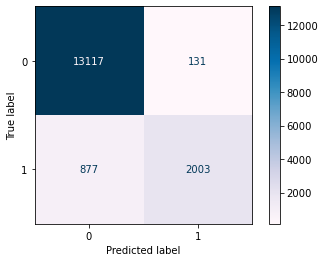

In [23]:
plot_confusion_matrix(lr, X_test_sc, y_test, cmap='PuBu');


In [24]:
lr_sens = tp / (tp + fn)

print(f"Sensitivity score: ", lr_sens)

Sensitivity score:  0.6954861111111111


In [25]:
lr_spec = tn / (tn + fn)

print(f"Specificity score: ", lr_spec)

Specificity score:  0.9373302844076032


In [26]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     13248
           1       0.94      0.70      0.80      2880

    accuracy                           0.94     16128
   macro avg       0.94      0.84      0.88     16128
weighted avg       0.94      0.94      0.93     16128



### Logistic Regression with PCA

In [27]:
pca = PCA(n_components=31, random_state=42)

pca.fit(X_train_sc)

Z_train = pca.transform(X_train_sc)
Z_test = pca.transform(X_test_sc)

In [28]:
logreg = LogisticRegression()

logreg.fit(Z_train, y_train)

print(f"Score on training data: ", lr.score(Z_train, y_train))
print(f"Score on testing data: ", lr.score(Z_test, y_test))

Score on training data:  0.8013560564412681
Score on testing data:  0.8053075396825397


In [29]:
pca_preds = logreg.predict(Z_test)

tn, fp, fn, tp = confusion_matrix(y_test, pca_preds).ravel()

print(confusion_matrix(y_test, pca_preds))

[[13117   131]
 [  877  2003]]


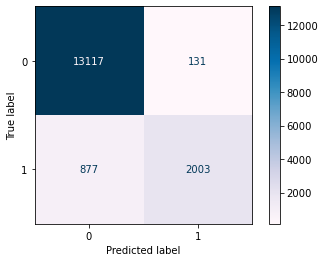

In [30]:
plot_confusion_matrix(logreg, Z_test, y_test, cmap='PuBu');

In [31]:
print(classification_report(y_test, pca_preds))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     13248
           1       0.94      0.70      0.80      2880

    accuracy                           0.94     16128
   macro avg       0.94      0.84      0.88     16128
weighted avg       0.94      0.94      0.93     16128



### Decision Tree Classifier

In [32]:
dtc = DecisionTreeClassifier()

dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [33]:
print(f'Score on training set: ', dtc.score(X_train, y_train))
print(f'Score on testing set: ', dtc.score(X_test, y_test))

Score on training set:  0.9993586219534543
Score on testing set:  0.9172247023809523


In [34]:
# now running the decision tree through a gridsearch
params = {'max_depth': [5, 10, 15, 20, 25, 30],
          'min_samples_split': [5, 10, 15, 20],
          'min_samples_leaf': [2, 4, 6, 8, 10],
          'ccp_alpha': [0, 0.001, 0.01, 1, 10]}

In [35]:
dt_grid = GridSearchCV(DecisionTreeClassifier(),
                       params,
                       cv=5)

dt_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [0, 0.001, 0.01, 1, 10],
                         'max_depth': [5, 10, 15, 20, 25, 30],
                         'min_samples_leaf': [2, 4, 6, 8, 10],
                         'min_samples_split': [5, 10, 15, 20]})

In [36]:
dt_grid.best_params_

{'ccp_alpha': 0.001,
 'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 5}

In [37]:
dt_grid.best_score_

0.9487507780499301

In [38]:
print(f'Score on training set: {dt_grid.score(X_train, y_train)}')
print(f'Score on testing set: {dt_grid.score(X_test, y_test)}')

Score on training set: 0.9504000977337975
Score on testing set: 0.9502728174603174


In [39]:
dt_preds = dt_grid.predict(X_test)

In [40]:
tn, fp, fn, tp = confusion_matrix(y_test, dt_preds).ravel()

print(confusion_matrix(y_test, dt_preds))

[[13143   105]
 [  697  2183]]


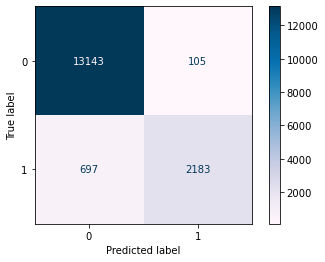

In [41]:
plot_confusion_matrix(dt_grid, X_test, y_test, cmap='PuBu');

In [42]:
dt_sens = tp / (tp + fn)

print(f"Sensitivity score: ", dt_sens)

Sensitivity score:  0.7579861111111111


In [43]:
dt_spec = tn / (tn + fn)

print(f"Specificity score: ", dt_spec)

Specificity score:  0.9496387283236994


In [44]:
print(classification_report(y_test, dt_preds))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     13248
           1       0.95      0.76      0.84      2880

    accuracy                           0.95     16128
   macro avg       0.95      0.88      0.91     16128
weighted avg       0.95      0.95      0.95     16128



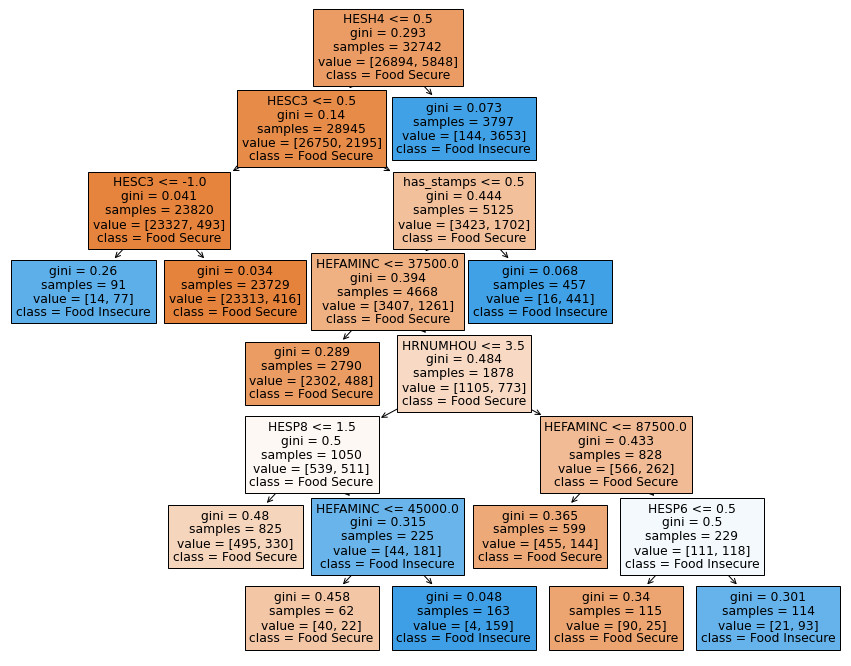

In [45]:
plt.figure(figsize = (15, 12))

# Plot our tree.
plot_tree(dt_grid.best_estimator_,
          feature_names = X_train.columns,
          class_names = ['Food Secure', 'Food Insecure'],
          filled = True);

### Bag of Trees

In [46]:
base_tree = DecisionTreeClassifier()

bag = BaggingClassifier(base_estimator=base_tree,
                        n_estimators=10,
                        bootstrap=True,
                        random_state=42)

In [47]:
bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)

In [48]:
print(f"Score on training data:", bag.score(X_train, y_train))
print(f"Score on testing data:", bag.score(X_test, y_test))

Score on training data: 0.9928532160527762
Score on testing data: 0.9471106150793651


In [49]:
bag_preds = bag.predict(X_test)

In [50]:
tn, fp, fn, tp = confusion_matrix(y_test, bag_preds).ravel()

print(confusion_matrix(y_test, bag_preds))

[[13025   223]
 [  630  2250]]


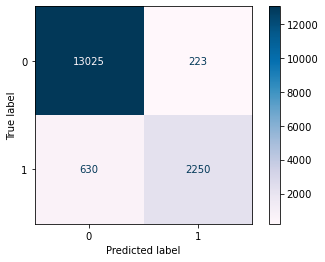

In [51]:
plot_confusion_matrix(bag, X_test, y_test, cmap='PuBu');

In [52]:
bag_sens = tp / (tp + fn)

print(f"Sensitivity score: ", bag_sens)

Sensitivity score:  0.78125


In [53]:
bag_spec = tn / (tn + fn)

print(f"Specificity score: ", bag_spec)

Specificity score:  0.9538630538264372


In [54]:
print(classification_report(y_test, bag_preds))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     13248
           1       0.91      0.78      0.84      2880

    accuracy                           0.95     16128
   macro avg       0.93      0.88      0.90     16128
weighted avg       0.95      0.95      0.95     16128



### Random Forest

In [55]:
rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)

RandomForestClassifier()

In [56]:
print(f"Score on training data:", rfc.score(X_train, y_train))
print(f"Score on testing data:", rfc.score(X_test, y_test))

Score on training data: 0.999328080141714
Score on testing data: 0.9500868055555556


In [57]:
rfc_params = {'max_depth': [5, 10, 15, 20, 25, 30],
              'max_features': [5, 10, 15, 20, 25, 30],
              'min_samples_split': [5, 10, 15, 20]}

In [58]:
rf_grid = GridSearchCV(rfc,
                       rfc_params,
                       cv=5)

rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15, 20, 25, 30],
                         'max_features': [5, 10, 15, 20, 25, 30],
                         'min_samples_split': [5, 10, 15, 20]})

In [59]:
rf_grid.best_params_

{'max_depth': 30, 'max_features': 25, 'min_samples_split': 20}

In [60]:
print(f"Score on training data:", rf_grid.score(X_train, y_train))
print(f"Score on testing data:", rf_grid.score(X_test, y_test))

Score on training data: 0.9654877527334922
Score on testing data: 0.953125


In [61]:
rf_preds = rf_grid.predict(X_test)

In [62]:
tn, fp, fn, tp = confusion_matrix(y_test, rf_preds).ravel()

print(confusion_matrix(y_test, rf_preds))

[[13105   143]
 [  613  2267]]


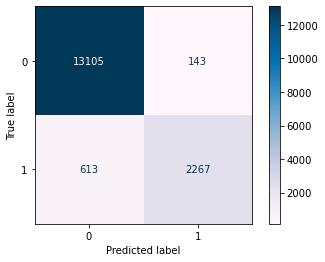

In [63]:
plot_confusion_matrix(rf_grid, X_test, y_test, cmap='PuBu');

In [64]:
rf_sens = tp / (tp + fn)

print(f"Sensitivity score: ", rf_sens)

Sensitivity score:  0.7871527777777778


In [65]:
rf_spec = tn / (tn + fn)

print(f"Specificity score: ", rf_spec)

Specificity score:  0.9553141857413617


In [66]:
print(classification_report(y_test, rf_preds))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     13248
           1       0.94      0.79      0.86      2880

    accuracy                           0.95     16128
   macro avg       0.95      0.89      0.91     16128
weighted avg       0.95      0.95      0.95     16128



### Support Vector Machine

In [67]:
from sklearn.svm import SVC

In [68]:
svc = SVC()

svc.fit(X_train_sc, y_train)

SVC()

In [69]:
print(f"Score on training set:", svc.score(X_train_sc, y_train))
print(f"Score on testing set:", svc.score(X_test_sc, y_test))

Score on training set: 0.9532099444139026
Score on testing set: 0.9467385912698413


In [70]:
svc_preds = svc.predict(X_test_sc)

In [71]:
tn, fp, fn, tp = confusion_matrix(y_test, svc_preds).ravel()

print(confusion_matrix(y_test, svc_preds))

[[13116   132]
 [  727  2153]]


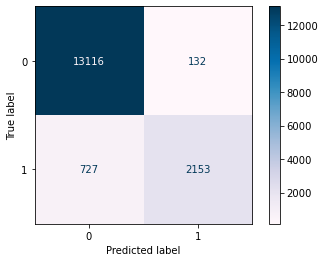

In [72]:
plot_confusion_matrix(svc, X_test_sc, y_test, cmap='PuBu');

In [73]:
print(classification_report(y_test, svc_preds))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     13248
           1       0.94      0.75      0.83      2880

    accuracy                           0.95     16128
   macro avg       0.94      0.87      0.90     16128
weighted avg       0.95      0.95      0.94     16128

